In [49]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import models

72.00694410958059


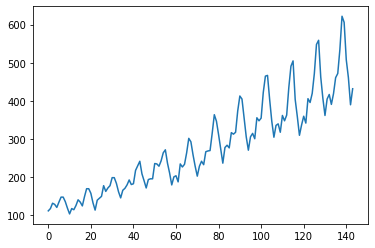

In [50]:
import polar_pla as pla
import numpy as np
from torch.autograd import Variable

# read in time series into temporary list
temp = []
f = open('DataSets/AirPassengers.csv', 'r')
for line in f:
    temp.append(float(line))

# run bottom up piecewise linear approximation on that list and store processed values
data = pla.bottom_up_pla(temp, 5)
#print(data)
# set the sequence length (the number of trends we look at to predict the next) and the train to test ratio
seq_length = 12
train_proportion = 0.8

In [51]:
def sliding_window(data):
    inputs = []
    outputs = []
    input_numpy = []
    out_numpy = []
    for i in range(0, len(data)-seq_length, 2):
        #inputs.append(data[i:(i+seq_length)]) # the next n are the input
        #outputs.append(data[i+seq_length:i+seq_length+2]) # and the one after that is the output
        input_numpy.append(np.array(data[i:(i+seq_length)]).reshape(int(seq_length/2),2))
        out_numpy.append(np.array(data[i+seq_length+1:i+seq_length+2]))
        
    return Variable(torch.Tensor(input_numpy)), Variable(torch.Tensor(out_numpy))

# convert data to tensor, and apply dataloader
total_data_input, total_data_output = sliding_window(data)
train_size = int(len(total_data_input)*train_proportion)

training_data_input = torch.narrow(total_data_input, 0, 0, train_size)
training_data_output = torch.narrow(total_data_output, 0, 0, train_size)

testing_data_input = torch.narrow(total_data_input, 0, train_size, len(total_data_input) - train_size)
testing_data_output = torch.narrow(total_data_output, 0, train_size, len(total_data_input) - train_size)

train = torch.utils.data.TensorDataset(training_data_input, training_data_output)
test = torch.utils.data.TensorDataset(testing_data_input, testing_data_output)

trainset = torch.utils.data.DataLoader(train, batch_size=32, shuffle=False)
testset = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

In [52]:
num_epochs = 100
learning_rate = 0.0001

num_classes = 1
input_size = 2
hidden_size = 128
num_layers = 1

model = models.LSTM(num_classes, input_size, hidden_size, num_layers)

#model = models.LSTM(num_classes, input_size, hidden_size, num_layers)

In [53]:
criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs+1):
    for i, (trainX, trainY) in enumerate(trainset):
        optimizer.zero_grad()
        outputs = model(trainX)
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.8f" % (epoch, loss.item()))

Epoch: 0, loss: 0.30045912
Epoch: 100, loss: 0.09275936


In [56]:
with torch.no_grad():
    correct = 0
    total_samples = 0
    for i, (trainX, trainY) in enumerate(testset):
        total_samples+=len(trainX)
        output = model(trainX)
        print(trainY)
        for x in range(len(output)):
            if (output[x][0]>0 and trainY[x][0]>0) or (output[x][0]<0 and trainY[x][0]<0):
                correct+=1
        model.zero_grad()
    print(f'Directional Accuracy: {correct*100/total_samples}')

tensor([[0.6251],
        [0.3752],
        [0.2504],
        [0.1396],
        [0.7223],
        [0.1534],
        [0.7778],
        [0.5973],
        [0.3613],
        [0.5834],
        [0.8750],
        [0.2226],
        [0.6529],
        [0.5834]])
Directional Accuracy: 100.0


In [ ]:
with torch.no_grad():
    correct = 0
    total_samples = 0
    for i, (trainX, trainY) in enumerate(testset):
        print(trainY.shape)
        total_samples+=len(trainX)
        output = lstm(trainX)
        for x in range(len(output)):

            if (output[x]>0 and trainY[x]>0) or (output[x]<0 and trainY[x]<0):
                correct+=1
        lstm.zero_grad()
    print(f'Directional Accuracy: {correct*100/total_samples}')